<a href="https://colab.research.google.com/github/SoumyaShreeram/Microlensing_with_NeuralNets/blob/master/04_Testing_NNs_without_Season_Gaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Testing Neural Networks with microlensing curves <mark/>without Season Gaps</mark>

The following notebook tests NNs on microlensed light curves that do not contain season gaps.

Author: Soumya Shreeram <br>
Script adapted from: Millon Martin & Kevin Müller <br>
Date: 23rd February 2020

Import all required python libraries

In [1]:
from google.colab import drive
import os
import pickle
import importlib
import itertools

import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import random
import os
from IPython.display import Image, SVG

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, InputSpec
from tensorflow.python.keras.layers import Conv1D, Conv2D
from tensorflow.python.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Add, BatchNormalization, concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

TensorFlow 1.x selected.


Mount google drive

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Directory where the `python` files are stored on Google Drive. These imported files are also available in `.ipynb` format on the GitHub repo with same names (without the nb; <strike>`dr`</strike>`0X_sameFileName`). nb stands for notebook. 

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

import nb_02i_preprocessing_data as dat
import nb_03_neural_network_designs as nnet

Setting up the path to the data directory

In [0]:
current_dir = os.getcwd()
data_dir = r'/content/gdrive/My Drive/training_set_microlensing/'
save_image_dir = r'/content/gdrive/My Drive/Colab Notebooks/Images/'
save_model_dir = r'/content/gdrive/My Drive/Colab Notebooks/Models/'

### 1. Input parameters

In [0]:
v_t = [500, 300] # transverse velcity
v_t_idx = 0 # choose index value for the velocity you would like (0 or 1)
r_0 = (2,4,10,15,20,30,40,60,80,100) # scale radius
output_class_names = [str(r) for r in r_0 ]

# if with season gaps == True; else False
season_gaps = False

# if using the new data set generated by Eric
new_data_set = True

### 2. Load the data

There are 10 categories into which the light-curves are classified. Each category is represented by the scale radius `r_0`. For every scale radius, there exists a light-curve whose data points are stored in the 3D array `l_curves`.

In [16]:
# sets the sampling parameters
sample_params = dat.setSamplingParameters(v_t[v_t_idx], data_dir, season_gaps)

# initializes data arrays
class_cat, l_curves, out_catergories, out_radii = dat.initializer(r_0, \
                                                                  sample_params)

for idx, rad in enumerate(r_0):
  filename = dat.getFilename(data_dir, idx, rad, v_t[v_t_idx], sample_params, \
                             season_gaps, new_data_set)
  
  # load data from the file
  importlib.reload(dat)
  l_curves, mjhd,_ = dat.loadData(filename, idx, l_curves, sample_params, idx, \
                                  season_gaps, new_data_set)
  out_catergories[idx*sample_params[0][idx]:(idx+1)*sample_params[0][idx]] = class_cat[1][idx]
  out_radii[idx*sample_params[0][idx]:(idx+1)*sample_params[0][idx]] = r_0[idx]

print('Shape of light curves vector:', np.shape(l_curves))

Shape of light curves vector: (50000, 4546, 1)


In [0]:
print("shape of light curves arrays:", np.shape(l_curves))
dat.saveFile(data_dir, 'lightcurves_NoSeasonGaps', l_curves)

shape of light curves arrays: (10000, 4546, 1)
File saved


#### 2.1 Plots of some random light-curves

Radii: 2.0 4.0


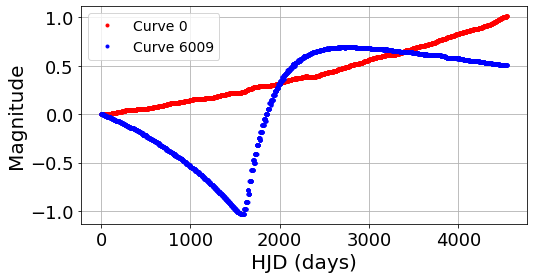

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
n = [0, 6009]
# light cureves without interpolation
ax.plot(l_curves[n[0], :, 0], 'r.', label='Curve %i'%(n[0]))
ax.plot(l_curves[n[1], :, 0], 'b.', label='Curve %i'%(n[1]))

dat.setLabels(ax, 'HJD (days)', 'Magnitude', ticks=True, legend=True)
print('Radii:', out_radii[n[0]], out_radii[n[1]])

### 3. Generate training and testing data sets

In [0]:
train_l_curves, test_l_curves, onehot_train, \
onehot_test = dat.generateTestTrain(l_curves, out_catergories, out_radii, r_0)

trainX, trainy, testX, testy = train_l_curves, onehot_train, test_l_curves, onehot_test

### 4. Compiling the 3 networks

The three networks compiled here are coded in `04_Neural_Network_Designs.ipynb` that have been saved as `dr04_Neural_Network_Designs.py`, for ease of importing it. The python files can be found in the GitHub repo folder *python files*. 

Note that if you are running this from colab, need to have these `.py` files in your drive folder *Colab Notebooks*. 

Default constants that can be modified.

In [20]:
# choose which network to use (default CNN2)
CNN1, CNN2, ResNet = False, False,True

model_types = [CNN1, CNN2, ResNet]
model_name_list = ['CNN1','CNN2','ResNet']

for i in range(len(model_name_list)):
  if model_types[i]:
    model_name = model_name_list[i]
print('Using the Neural Network:', model_name)

Using the Neural Network: ResNet


The following code block uses the methods defined in the file `dr04_Neural_Network_Designs.py`: imported as **`nnet`**

Model parameters are defined in the methods in **`nnet`** additionally some more details:
* `num_hidden_nodes`: number of nodes in hidden fully connected layer
*`dropout_ratio`: % of nodes in the hidden layer to dropout during back-propagation update of the network weights

#### 4.1 Bulding the model CNN1

Poor man's approach at writing a simple CNN to test the data.

In [0]:
if CNN1:
  importlib.reload(nnet)
  
  # model architecture parameters
  n_filters = [32, 32, 44]
  kern_sizes = [21,21,15,15]
  maxpoolsize = [2, 15, 2, 15]
  n_hidden_nodes = 1500

  # training/fitting parameters
  verbose, epochs, batch_size = 1 , 10, 60
  loss, optimizer, metrics ='categorical_crossentropy', 'adam', ['accuracy']
  validation_split=0.2

  # building the model
  model = nnet.buildModelCNN1(sample_params[2], n_filters[0])

  # save a plot of the model
  plot_model(model, show_shapes=True, to_file='multichannel.png')

### 4.2 Building model CNN2

In [0]:
if CNN2:
  # reloads the file if any changes are made
  importlib.reload(nnet)
  trainX, trainy, testX, testy = train_l_curves, onehot_train, test_l_curves, onehot_test

  # CNN2 model parameters
  num_filter = (32, 32, 44, 44)
  kern_size = (21,21,15,15)
  maxpoolsize = (None, 15, None, 15)
  shortcut_link = (0,1,2,3)
  batch_norm = False
  dropout_ratio = 0.2  
  sampling = 3
  num_pieces = 1
  num_hidden_nodes = [1500]
  
  # prepare data with sample cuts with the correct shape
  testX_prep = nnet.prepareDataSampleCuts(testX, sampling, num_pieces)
  trainX_prep = nnet.prepareDataSampleCuts(trainX, sampling, num_pieces)

  # build the model
  inputs, outputs = nnet.buildModelCNN2(sample_params[2], num_filter, kern_size, \
                                                  maxpoolsize, num_hidden_nodes, \
                                                  dropout_ratio, shortcut_link, \
                                                  batch_norm, trainX_prep.shape[1], r_0)
  
  # optimization, compilation parameters
  optimizer_type = Adam(lr=5e-4)  
  loss = 'categorical_crossentropy'  
  metrics = ['categorical_accuracy'] 

  # compiles the model
  model = nnet.compileDisplayNetwork(inputs, outputs, optimizer_type, loss, \
                                    metrics, save_image_dir+'CNN2', True)
    
  print('Network created')

### 4.3 Compling model ResNet

In [0]:
if ResNet:
  # reloads the file if any changes are made
  importlib.reload(nnet)

  # ResNet model parameters
  num_filter = (32, 32, 32)
  kern_size = (10,20,50)
  n_block = 5
  maxpoolsize = 3
  num_hidden_nodes =[1000.0,]
  dropout_ratio = 0.7 
  batch_norm = True
  sampling = 1
  num_pieces = 1

  # build network
  inputs, outputs = nnet.defineNetworkDesignResnet(sample_params[2], num_filter, kern_size, n_block, \
                                 maxpoolsize, num_hidden_nodes, dropout_ratio, r_0,\
                                 batch_norm)
  
  # ResNet compilation parameters
  learning_rate = 1e-4
  max_epochs = 80
  decay = learning_rate/max_epochs
  optimizer_type = Adam(lr=learning_rate, decay=decay)  
  loss = 'categorical_crossentropy'  
  metrics = ['categorical_accuracy'] 

  # compiles network
  model = nnet.compileDisplayNetwork(inputs, outputs, optimizer_type, loss, \
                                     metrics,save_image_dir+'ResNet', True)
  
  #model.load_weights('/content/gdrive/My Drive/Colab_Notebooks/Deep_learning_for_optical_IMaging/Resnet_weights.h5')
  print('Network created')

### 5. Optimizing the network

* `validation_split_ratio`: Percentage of the seen dataset to be put aside for validation, rest is for training
* `max_epochs`: maxmimum number of epochs to be iterated
* `batch_size`: batch size for the training data set

In [0]:
validation_split_ratio = 0.2  
max_epochs = 30  
batch_size = 60 
num_inputs = 1
verbose = 1

# series of values to be optimized
batch_size_arr = [20, 40, 60, 80, 100, 120]
learning_rate_arr = [1e-4, 1e-3, 1e-2, 1e-1]
dropout_ratio_arr = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

#### 5.1 Optimizing batch size

In [0]:
if CNN1:
  model_history, accuracy = nnet.compileFitEvaluateModel(model, trainX, trainy, testX, testy, loss, optimizer, metrics,\
                                                       verbose, epochs, batch_size, validation_split)

results_arr = []
for batch_size in batch_size_arr:  
  # trains the model
  model, model_history = nnet.trainModel(model, trainX, trainy, batch_size, max_epochs,\
                                    validation_split_ratio, verbose)

  # evaluates and predicts the results from the trained model
  results, predictions = nnet.evaluatePredictModel(model, testX, testy, verbose = 1)  
  results_arr.append(results)

  # prints ongoing progress
  print('Training completed for batch_size %d'%batch_size)
  print('batch_size %d:'%batch_size + ' [test loss, test acc] = ', results)

#### 5.2 Optimizing learning rate

In [0]:
results_lr_arr = []
importlib.reload(nnet)

for learning_rate in learning_rate_arr:  
  # compile model
  model = nnet.compileResNet(sample_params, r_0, save_image_dir, learning_rate, momentum)


  # trains the model
  model, model_history = nnet.trainModel(model, trainX, trainy, batch_size, max_epochs,\
                                    validation_split_ratio, verbose)

  # evaluates and predicts the results from the trained model
  results, predictions = nnet.evaluatePredictModel(model, testX, testy, verbose = 1)  
  results_lr_arr.append(results)

  # prints ongoing progress
  print('Training completed for learning rate %d'%learning_rate)
  print('learning rate %d:'%learning_rate + ' [test loss, test acc] = ', results)

### 6. Training the network on the optimized parameters

In [23]:
if CNN2:
  # reshaped data is used while training
  trainX = trainX_prep
  testX = testX_prep

# trains the model
model, model_history = nnet.trainModel(model, trainX, trainy, batch_size, max_epochs,\
                                  validation_split_ratio, verbose)

# evaluates and predicts the results from the trained model
results, predictions = nnet.evaluatePredictModel(model, testX, testy, verbose = 1) 

print('[test loss, test acc] = ', results)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 102s 3ms/sample - loss: 2.2145 - categorical_accuracy: 0.1806 - val_loss: 1.9220 - val_categorical_accuracy: 0.2299
Epoch 2/30
32000/32000 [==============================] - 94s 3ms/sample - loss: 1.8788 - categorical_accuracy: 0.2506 - val_loss: 1.7585 - val_categorical_accuracy: 0.2962
Epoch 3/30
32000/32000 [==============================] - 94s 3ms/sample - loss: 1.7710 - categorical_accuracy: 0.2970 - val_loss: 1.6931 - val_categorical_accuracy: 0.3372
Epoch 4/30
32000/32000 [==============================] - 94s 3ms/sample - loss: 1.6575 - categorical_accuracy: 0.3538 - val_loss: 1.7252 - val_categorical_accuracy: 0.3295
Epoch 5/30
32000/32000 [==============================] - 94s 3ms/sample - loss: 1.4995 - categorical_accuracy: 0.4160 - val_loss: 1.3823 - val_categorical_accuracy: 0.4631
Epoch 6/30
32000/32000 [==============================] - 93s 3ms/sample - loss: 1.36

#### 6.1 Plotting loss-accuracy curves

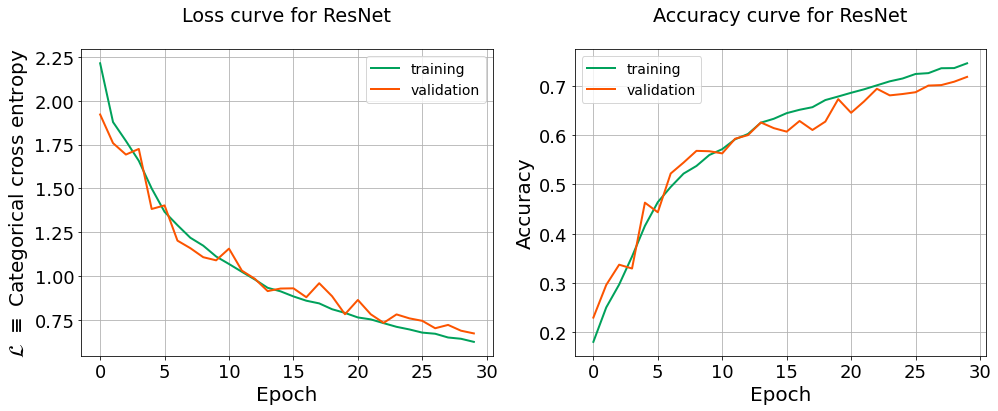

In [24]:
# plots the history
fig, ax = plt.subplots(1,2, figsize=(14,6))
labels = ['training', 'validation']
loss_Accuracy = ['loss', 'val_loss', 'categorical_accuracy', 'val_categorical_accuracy']

model_history = model_history.history
dat.plotLoss(ax[0], model_history, loss_Accuracy, model_name, labels)
dat.plotAccuracy(ax[1], model_history, loss_Accuracy, model_name, labels)
 
fig.savefig(save_image_dir+'/LandA_%s_epochs_%d_noSeasonGaps.png'%(model_name, max_epochs))    
fig.tight_layout()

#### 6.2 Displaying the classification report, confusion matrix

In [25]:
y_predict = np.argmax(predictions, axis=1)
y_test = np.argmax(testy, axis=1)

print('Test set classification report:\n')
print(classification_report(y_test, y_predict,  \
                            target_names=output_class_names))

Test set classification report:

              precision    recall  f1-score   support

           2       0.93      0.93      0.93      1006
           4       0.89      0.91      0.90       983
          10       0.91      0.87      0.89       976
          15       0.82      0.86      0.84       993
          20       0.90      0.71      0.79       969
          30       0.74      0.76      0.75       999
          40       0.74      0.45      0.56      1007
          60       0.55      0.84      0.66      1000
          80       0.45      0.41      0.43      1038
         100       0.48      0.52      0.50      1029

    accuracy                           0.72     10000
   macro avg       0.74      0.73      0.72     10000
weighted avg       0.74      0.72      0.72     10000



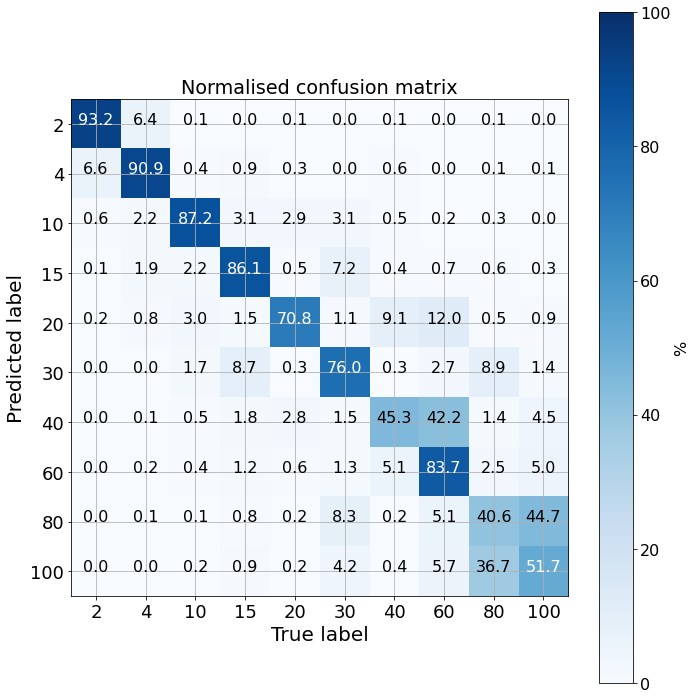

In [26]:
# need this to avoid callback errors
from sklearn.metrics import confusion_matrix
importlib.reload(dat)

# generate confusion matrix
cfm = confusion_matrix(y_test, y_predict)  

# row normalisation of confusion matrix
cfm_probability = cfm.astype('float')/cfm.sum(axis=1)[:, np.newaxis]  
# confusion probability matrix
cfm_probability = cfm_probability * 100.0  

fig, ax = plt.subplots(1,1, figsize=(10,10))
dat.plotConfusionMatrix(ax, cfm_probability, output_class_names, 0)

# save figure
fig.savefig(save_image_dir+'/cfm_%s_epochs_%d_noSeasonGaps.png'%(model_name, max_epochs))    
fig.tight_layout()